# What is the difference between yolort and yolov5

Now `yolort` adopts the same model structure as the official `yolov5`. The main difference between yolort and YOLOv5 is the strategy in pre-processing and post-processing. The main reason we have adopted a different strategy from the official one is to enable the pre-processing and post-processing modules to be jit traceable and scriptable. From this we can gain an end-to-end Graph for inferencing on `LibTorch`, `ONNX Runtime` and `TVM`.

For pre-processing, YOLOv5 uses the [letterboxing (padding)](https://en.wikipedia.org/wiki/Letterboxing_(filming)) resizing that maintains the aspect ratio. The error arises from the `interpolate` operator used in resizing. YOLOv5 uses the [cv2.resize](https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#ga47a974309e9102f5f08231edc7e7529d) operator on the input `uint8 [0-255]` images, the operators in OpenCV are not traceable or scriptable, so we use [torch.nn.functional.interpolate](https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html#torch-nn-functional-interpolate) in yolort. Fortunately, the `interpolation` operator of PyTorch is [aligned](https://github.com/pytorch/vision/issues/2950#issuecomment-723038041) with that of OpenCV, however PyTorch's `interpolate` [only supports](https://github.com/pytorch/pytorch/issues/5580) the float data type now, we can only operate with images cast to float types, and therefore there will introduce some errors.

YOLOv5 provides a very powerful function to do the post-processing, of which we implement only a non-agnostic version, but the accuracy here should be able to be consistent with the original version. See our [doc](https://zhiqwang.com/yolov5-rt-stack/notebooks/how-to-align-with-ultralytics-yolov5.html) for more details.

## Prepare environment, image and model weights to test

In [1]:
import os
import torch

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import cv2
from yolort.models import YOLOv5
from yolort.utils import Visualizer, cv2_imshow, read_image_to_tensor
from yolort.utils.image_utils import parse_single_image
from yolort.v5 import load_yolov5_model, letterbox, non_max_suppression, scale_coords, attempt_download
from yolort.v5.utils.downloads import safe_download

In [3]:
img_size = 640
stride = 64
score_thresh = 0.35
nms_thresh = 0.45
fixed_shape = None

In [4]:
# img_source = "https://huggingface.co/spaces/zhiqwang/assets/resolve/main/bus.jpg"
img_source = "https://huggingface.co/spaces/zhiqwang/assets/resolve/main/zidane.jpg"
img_path = img_source.split("/")[-1]
safe_download(img_path, img_source)

  0%|          | 0.00/165k [00:00<?, ?B/s]

In [5]:
# Downloaded from 'https://github.com/ultralytics/yolov5/releases/download/v6.1/yolov5s6.pt'
model_path = 'yolov5s6.pt'
checkpoint_path = attempt_download(model_path)

## Load model as ultralytics and inference

YOLOv5 provides an input-robust model wrapper named `AutoShape` for passing cv2/np/PIL/torch inputs, which includes pre-processing, inference and post-processing (NMS). This wrapper is currently only valid for pytorch inference. To peel back the essence of what's inside, we use a vanilla interface to call yolov5. We do the pre-processing part first.

In [6]:
# Preprocess
img_raw = cv2.imread(img_path)

img_shape = (img_size, img_size)
auto_rectangle = not fixed_shape
image = letterbox(img_raw, new_shape=img_shape, stride=stride, auto=auto_rectangle)[0]
image = read_image_to_tensor(image)
image = image.to(device)
image = image[None]

In [7]:
vis = parse_single_image(image[0])

Let's visualize the letterboxed image by the way.

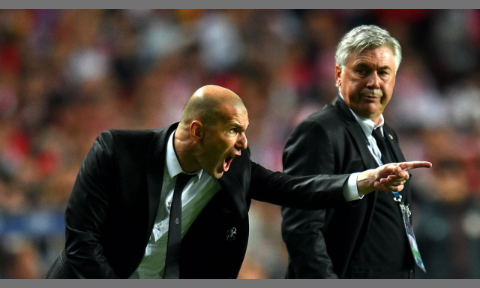

In [8]:
cv2_imshow(vis, imshow_scale=0.75, convert_bgr_to_rgb=False)

In [9]:
model_yolov5 = load_yolov5_model(checkpoint_path)
model_yolov5 = model_yolov5.to(device)
model_yolov5 = model_yolov5.eval()

In [10]:
with torch.no_grad():
    yolov5_dets = model_yolov5(image)
    yolov5_dets = non_max_suppression(yolov5_dets, score_thresh, nms_thresh, agnostic=False)[0]

/opt/conda/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Then restore the coordinates to the original scale of the image.

In [11]:
boxes_yolov5 = scale_coords(image.shape[2:], yolov5_dets[:, :4], img_raw.shape[:-1])
labels_yolov5 = yolov5_dets[:, 5].to(dtype=torch.int64)
scores_yolov5 = yolov5_dets[:, 4]

Now we can visualize the inference results after completing the post-processing. And set the label names first.

In [12]:
label_source = "https://huggingface.co/spaces/zhiqwang/assets/resolve/main/coco.names"
label_path = label_source.split("/")[-1]
safe_download(label_path, label_source)

  0%|          | 0.00/621 [00:00<?, ?B/s]

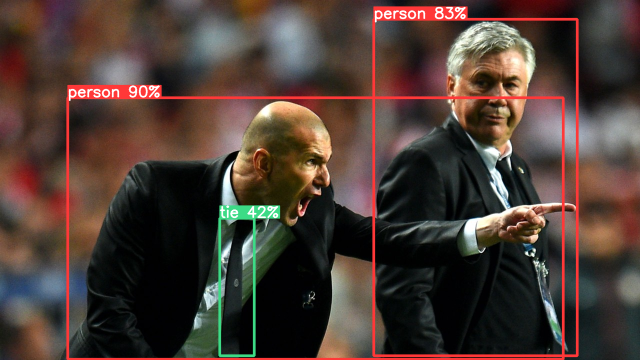

In [13]:
v = Visualizer(img_raw, metalabels=label_path)
# Prepare the prediction labels for the Visualizer
predictions = {"boxes": boxes_yolov5, "labels": labels_yolov5, "scores": scores_yolov5}
v.draw_instance_predictions(predictions)
v.imshow(scale=0.5)

At that moment we have completed the whole inference process of yolov5.

## Use yolort's approach to inferencing

yolort now supports loading models trained by yolov5. Here is also an end-to-end inference pipeline, and this pipeline supports both jit tracing and scripting modes. This model can be used to export ONNX and torchscript graph and to inference on ONNX Runtime, LibTorch and TVM VirtualMachine backends.

In [14]:
model_yolort = YOLOv5.load_from_yolov5(
    checkpoint_path,
    score_thresh=score_thresh,
    nms_thresh=nms_thresh,
    size_divisible=stride,
    fixed_shape=fixed_shape,
)

model_yolort = model_yolort.eval()
model_yolort = model_yolort.to(device)

Its interface is also very easy to use.

In [15]:
with torch.no_grad():
    yolort_dets = model_yolort.predict(img_path)

In [16]:
boxes_yolort = yolort_dets[0]['boxes']
labels_yolort = yolort_dets[0]['labels']
scores_yolort = yolort_dets[0]['scores']

## Verify the detection results between yolort and ultralytics

We print out the results of both inferencing.

In [17]:
print(f"Detection boxes with yolov5:\n{boxes_yolov5}\n")
print(f"Detection boxes with yolort:\n{boxes_yolort}")

Detection boxes with yolov5:
tensor([[ 135.26688,  195.07532, 1126.30615,  718.77856],
        [ 747.54639,   38.90421, 1154.26477,  711.03455],
        [ 439.68539,  436.93619,  508.41635,  711.93982]], device='cuda:0')

Detection boxes with yolort:
tensor([[ 135.69894,  195.08270, 1126.30603,  718.74518],
        [ 747.56873,   38.92401, 1154.24414,  710.97394],
        [ 439.69324,  436.99841,  508.36639,  712.00159]], device='cuda:0')


In [18]:
print(f"Detection scores with yolov5:\n{scores_yolov5}\n")
print(f"Detection scores with yolort:\n{scores_yolort}")

Detection scores with yolov5:
tensor([0.90279, 0.82556, 0.42047], device='cuda:0')

Detection scores with yolort:
tensor([0.90279, 0.82555, 0.42183], device='cuda:0')


In [19]:
print(f"Detection labels with yolort:\n{labels_yolov5}\n")
print(f"Detection labels with yolort:\n{labels_yolort}")

Detection labels with yolort:
tensor([ 0,  0, 27], device='cuda:0')

Detection labels with yolort:
tensor([ 0,  0, 27], device='cuda:0')


In [20]:
# Testing boxes
torch.testing.assert_allclose(boxes_yolort, boxes_yolov5, rtol=1e-2, atol=1e-7)
# Testing scores
torch.testing.assert_allclose(scores_yolort, scores_yolov5, rtol=1e-3, atol=1e-2)
# Testing labels
torch.testing.assert_allclose(labels_yolort, labels_yolov5)

print("Exported model has been tested, and the result looks good!")

Exported model has been tested, and the result looks good!


As you can see from this result, there are still some differences in the boxes, but the scores and labels are relatively accurate.